### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [22]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [23]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [24]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [33]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.96,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

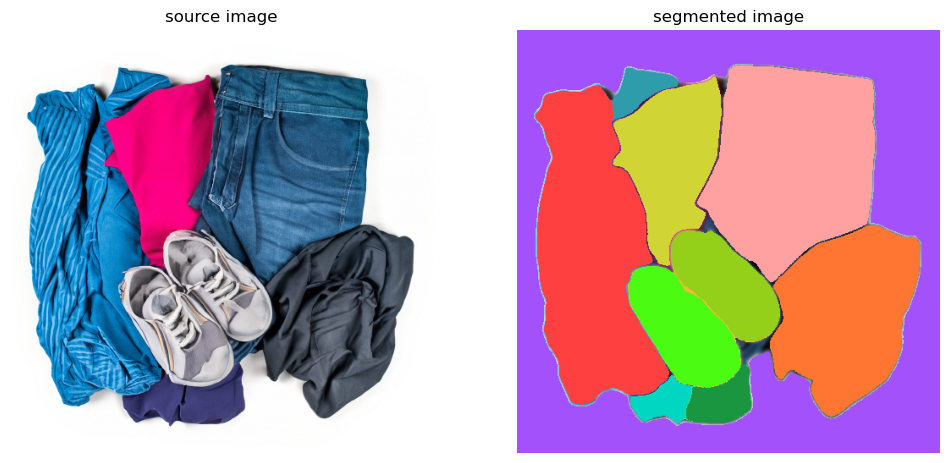

In [53]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = [((i / 255.0) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv2.LUT(image, table)

def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(cr)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result


file_name = 'mixed_0019.png'

img_path = get_training_data_path(file_name)
image_bgr = cv2.imread(img_path)
#image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# image_3ch = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(image_bgr, (11, 11), 0)
#blurred_image = remove_shadow_rgb(blurred_image)
masks = mask_generator.generate(blurred_image)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=blurred_image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_image = bounding_box_annotator.annotate(
    scene=blurred_image, detections=detections)

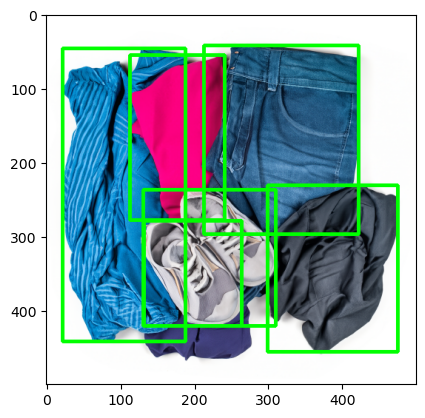

In [55]:
masks_cleaned = []
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 10000 and mask['area'] <= 50000):
        masks_cleaned.append(mask)

masked_image = image_rgb
for mask in masks_cleaned:
    x, y, w, h = mask['bbox']
    cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)

plt.imshow(masked_image)

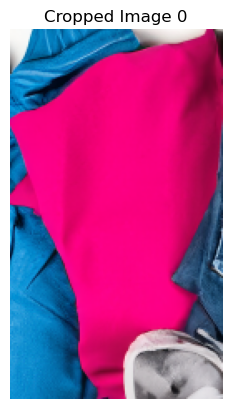

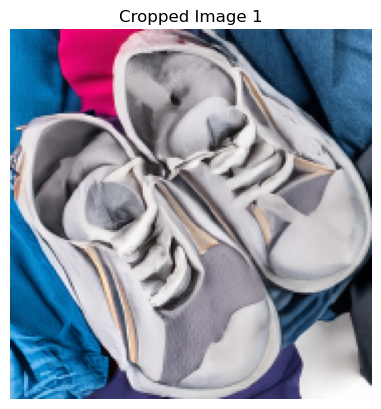

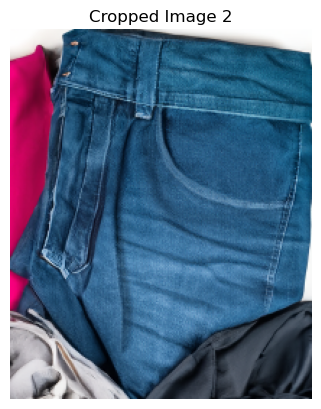

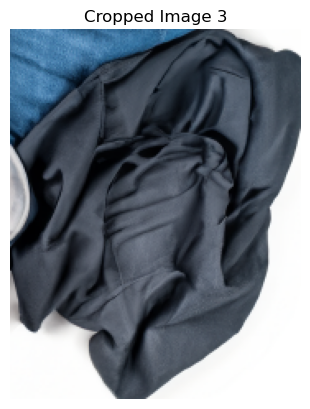

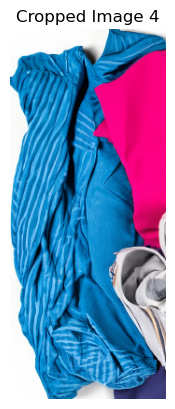

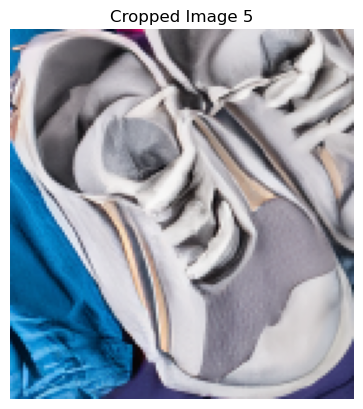

In [50]:
# Assuming 'image' is your original image and 'annotations' is a list of dictionaries containing annotations
from matplotlib import patches

img_path = get_training_data_path(file_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

for i, ann in enumerate(masks_cleaned):
    # Extract bounding box coordinates
    x, y, width, height = map(int, ann['bbox'])  # Ensure integer values
    
    # Define rectangular region
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    #mask = np.array(ann['segmentation'], dtype=np.uint8)
    #masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
        
    # Crop the region from the original image
    cropped_image = image_rgb[y:y+height, x:x+width]
    cropped_image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
    # Save the cropped image
    output_path = f"cropped_image_{i}.png"
    cv2.imwrite(output_path, cropped_image_bgr)

    # Optionally, visualize the cropped region
    plt.imshow(cropped_image)
    plt.title(f"Cropped Image {i}")
    plt.axis('off')
    plt.show()